## Single object mask combined on original image with 50 percent transaprency

loading annotations into memory...
Done (t=0.61s)
creating index...
index created!


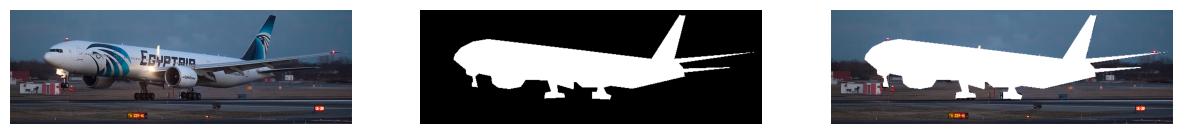

True

In [ ]:
import os
import random
import zipfile
import glob
import cv2
import numpy as np
from pycocotools.coco import COCO
from pycocotools import mask as mask_utils
import matplotlib.pyplot as plt

def download_file(url, dst):
    if not os.path.exists(dst):
        os.system(f"wget -c {url} -O {dst}")

def extract_zip(zip_path, extract_to="."):
    if not os.path.exists(extract_to) or not os.listdir(extract_to):
        with zipfile.ZipFile(zip_path, "r") as z:
            z.extractall(extract_to)


download_file("http://images.cocodataset.org/zips/val2017.zip", "val2017.zip")
extract_zip("val2017.zip", "val2017")
download_file("http://images.cocodataset.org/annotations/annotations_trainval2017.zip",
              "annotations_trainval2017.zip")
extract_zip("annotations_trainval2017.zip", "annotations")

# ---------- Robust annotation path ----------
ann_file = "annotations/instances_val2017.json"
if not os.path.exists(ann_file):
    nested_path = os.path.join("annotations", "annotations", "instances_val2017.json")
    if os.path.exists(nested_path):
        ann_file = nested_path
    else:
        raise FileNotFoundError(f"Cannot find {ann_file} or nested path.")


img_dir = "val2017"
coco = COCO(ann_file)


img_id = random.choice(coco.getImgIds())
img_info = coco.loadImgs(img_id)[0]

img_name = img_info['file_name']
possible_paths = glob.glob(f"{img_dir}/**/{img_name}", recursive=True)
if not possible_paths:
    raise FileNotFoundError(f"Could not find image {img_name} in {img_dir}")
img_path = possible_paths[0]

image = cv2.imread(img_path)
if image is None:
    raise FileNotFoundError(f"Failed to read image: {img_path}")
h, w = image.shape[:2]


ann_ids = coco.getAnnIds(imgIds=img_id)
if not ann_ids:
    raise ValueError("No objects found in this image")
ann = coco.loadAnns([random.choice(ann_ids)])[0]

seg = ann['segmentation']
mask = np.zeros((h, w), dtype=np.uint8)
if isinstance(seg, list):
    rles = mask_utils.frPyObjects(seg, h, w)
    rle = mask_utils.merge(rles)
else:
    rle = seg
mask = mask_utils.decode(rle)


overlay = image.copy()
overlay = cv2.addWeighted(overlay, 0.5, overlay, 0.5, 0)  # background 50% transparent
overlay[mask == 1] = 255  # object white


plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()


out_name = f"overlay_oneobj_white_{img_info['file_name'].replace('.jpg', '.png')}"
cv2.imwrite(out_name, overlay)


## Multiple subjects masks combined on original image



loading annotations into memory...
Done (t=0.59s)
creating index...
index created!


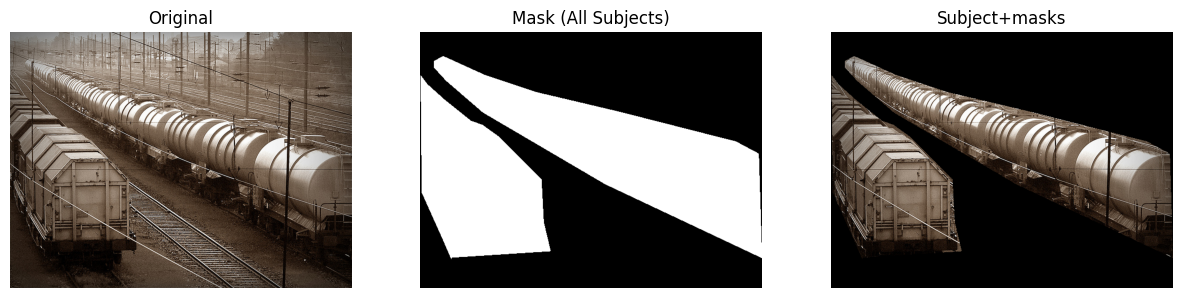

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import pycocotools.mask as mask_utils
import random
import glob

# --- Paths ---
ann_file = "annotations/annotations/instances_val2017.json"
img_dir = "val2017"

# --- Load COCO ---
coco = COCO(ann_file)

# --- Pick a random image ---
img_ids = coco.getImgIds()
img_id = random.choice(img_ids)
img_info = coco.loadImgs([img_id])[0]

# --- Find the image file recursively ---
img_file = img_info['file_name']
possible_paths = glob.glob(f"{img_dir}/**/{img_file}", recursive=True)
if not possible_paths:
    raise FileNotFoundError(f"Could not find {img_file} in {img_dir}")
img_path = possible_paths[0]

# --- Load image ---
image = cv2.imread(img_path)
if image is None:
    raise FileNotFoundError(f"Failed to read {img_path}")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w = image.shape[:2]

# --- Load all annotations ---
ann_ids = coco.getAnnIds(imgIds=[img_id])
anns = coco.loadAnns(ann_ids)

# --- Build combined mask for all subjects ---
mask = np.zeros((h, w), dtype=np.uint8)
for ann in anns:
    seg = ann['segmentation']
    if isinstance(seg, list):  # polygons
        rles = mask_utils.frPyObjects(seg, h, w)
        rle = mask_utils.merge(rles)
        m = mask_utils.decode(rle)
    elif isinstance(seg, dict) and "counts" in seg:  # already RLE
        m = mask_utils.decode(seg)
    else:
        continue
    mask = np.maximum(mask, m)


overlay = np.zeros_like(image)
overlay[mask == 1] = image[mask == 1]


plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(image); plt.axis('off'); plt.title("Original")
plt.subplot(1,3,2); plt.imshow(mask, cmap='gray'); plt.axis('off'); plt.title("Mask (All Subjects)")
plt.subplot(1,3,3); plt.imshow(overlay); plt.axis('off'); plt.title("Subject+masks")
plt.show()


## Main subject identification and it's mask overlay,semi transparent

loading annotations into memory...
Done (t=0.67s)
creating index...
index created!


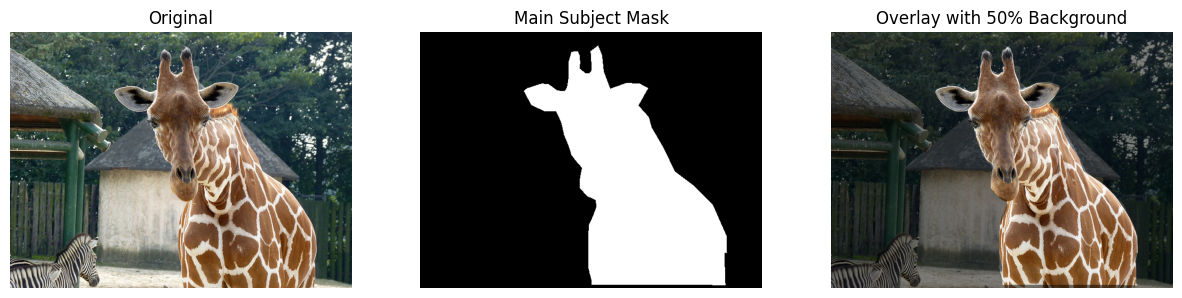

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import pycocotools.mask as mask_utils
import random
import glob


ann_file = "annotations/annotations/instances_val2017.json"
img_dir = "val2017"


coco = COCO(ann_file)


img_ids = coco.getImgIds()
img_id = random.choice(img_ids)
img_info = coco.loadImgs([img_id])[0]


img_file = img_info['file_name']
possible_paths = glob.glob(f"{img_dir}/**/{img_file}", recursive=True)
if not possible_paths:
    raise FileNotFoundError(f"Could not find {img_file} in {img_dir}")
img_path = possible_paths[0]


image = cv2.imread(img_path)
if image is None:
    raise FileNotFoundError(f"Failed to read {img_path}")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w = image.shape[:2]


ann_ids = coco.getAnnIds(imgIds=[img_id])
anns = coco.loadAnns(ann_ids)


max_area = 0
main_mask = np.zeros((h, w), dtype=np.uint8)
for ann in anns:
    seg = ann['segmentation']
    if isinstance(seg, list):
        rles = mask_utils.frPyObjects(seg, h, w)
        rle = mask_utils.merge(rles)
        m = mask_utils.decode(rle)
    elif isinstance(seg, dict) and "counts" in seg:
        m = mask_utils.decode(seg)
    else:
        continue
    area = np.sum(m)
    if area > max_area:
        max_area = area
        main_mask = m


overlay = image.copy().astype(np.float32)
# Background 50% transparent
overlay[main_mask == 0] = overlay[main_mask == 0] * 0.5
# Main subject remains original color
overlay = overlay.astype(np.uint8)


plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(image); plt.axis('off'); plt.title("Original")
plt.subplot(1,3,2); plt.imshow(main_mask, cmap='gray'); plt.axis('off'); plt.title("Main Subject Mask")
plt.subplot(1,3,3); plt.imshow(overlay); plt.axis('off'); plt.title("Overlay with 50% Background")
plt.show()


## Machine learning model output from ground truth and it's learning

Epoch 1 Loss: 0.5543878078460693
Epoch 2 Loss: 0.565356969833374
Epoch 3 Loss: 0.5703142881393433


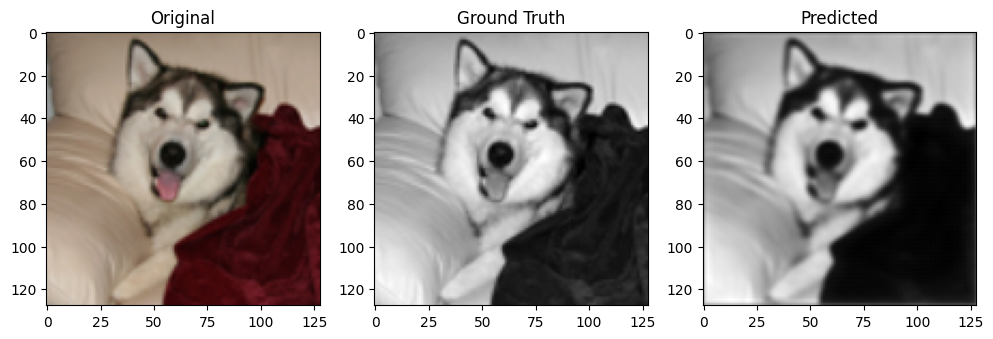

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# ---- 1. Dataset with soft grayscale masks ----
class HighResSegDataset(Dataset):
    def __init__(self, num_images=50, transform=None):
        self.num_images = num_images
        self.transform = transform
        self.stl10 = datasets.STL10(root='./data', download=False, split='train')

    def __len__(self):
        return self.num_images

    def __getitem__(self, idx):
        image, _ = self.stl10[idx]
        mask = image.convert("L")  # grayscale soft mask

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)  # resize mask to same size as image

        return image, mask



# ---- 2. High-res U-Net with skip connections ----
class HighResUNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU()
        )
        self.pool = nn.MaxPool2d(2,2)
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU()
        )
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 128, 3, padding=1), nn.ReLU()
        )
        # Decoder
        self.upconv2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(64+128, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 32, 3, padding=1), nn.ReLU()
        )
        self.upconv1 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(16+64, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 1, 1)
        )

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool(e1)
        e2 = self.enc2(p1)
        p2 = self.pool(e2)
        b = self.bottleneck(p2)
        u2 = self.upconv2(b)
        cat2 = torch.cat([u2, e2], dim=1)
        d2 = self.dec2(cat2)
        u1 = self.upconv1(d2)
        cat1 = torch.cat([u1, e1], dim=1)
        out = self.dec1(cat1)
        return torch.sigmoid(out)

# ---- 3. Training ----
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

dataset = HighResSegDataset(transform=transform)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

model = HighResUNet()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train for a few batches (demo)
for epoch in range(3):
    for imgs, masks in loader:
        preds = model(imgs)
        loss = criterion(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} Loss: {loss.item()}")

# ---- 4. Visualization ----
imgs, masks = next(iter(loader))
with torch.no_grad():
    preds = model(imgs)

plt.figure(figsize=(12,4))
for i in range(len(imgs)):
    plt.subplot(1,3,1); plt.imshow(np.transpose(imgs[i].numpy(), (1,2,0))); plt.title("Original")
    plt.subplot(1,3,2); plt.imshow(masks[i][0], cmap="gray"); plt.title("Ground Truth")
    plt.subplot(1,3,3); plt.imshow(preds[i][0], cmap="gray"); plt.title("Predicted")
    plt.show()
    break


## Model architecture:U-net commonly used for image segmentation

encoder-find textures,features,zooming out of an image to find patterns,all outlines are drawn perfectly,precisely,focuses on the details then defines the subject||bottleneck-smallest,most compressed form of the image,to represent the image in most compressed form,then goes to decoder||
decoder-zooming in,expands compressed mask to reconstructs it

Using device: cuda


100%|██████████| 792M/792M [00:38<00:00, 20.8MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 10.1MB/s]



Starting Training on Oxford-IIIT Pet Dataset...
--- Epoch [1/25] Finished --- Avg Loss: 0.4317 --- LR: 0.001 ---
--- Epoch [2/25] Finished --- Avg Loss: 0.3384 --- LR: 0.001 ---
--- Epoch [3/25] Finished --- Avg Loss: 0.2918 --- LR: 0.001 ---
--- Epoch [4/25] Finished --- Avg Loss: 0.2614 --- LR: 0.001 ---
--- Epoch [5/25] Finished --- Avg Loss: 0.2396 --- LR: 0.001 ---


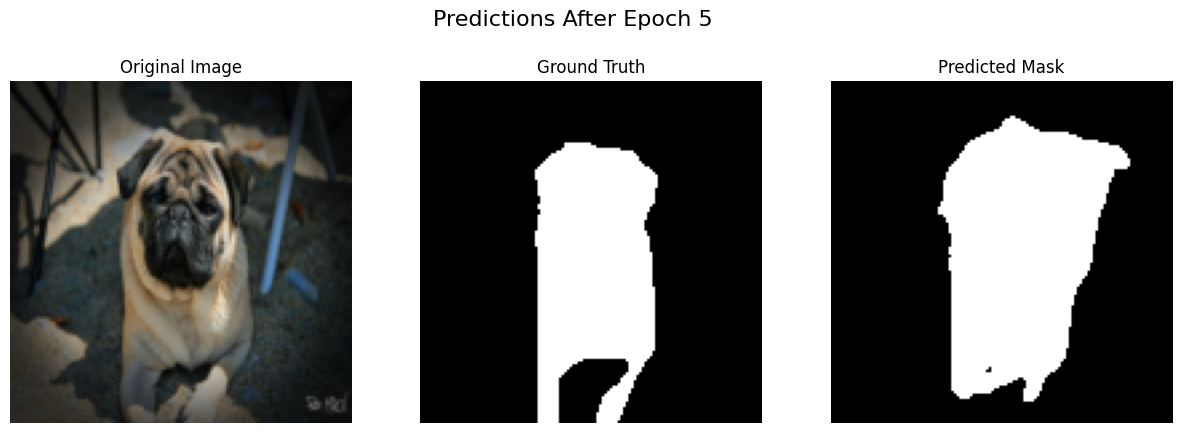

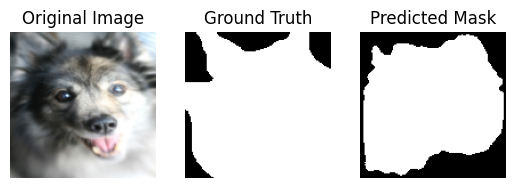

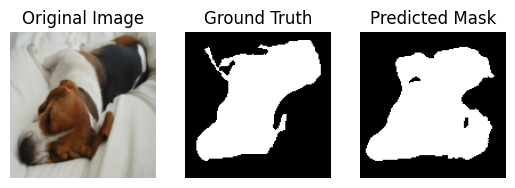

--- Epoch [6/25] Finished --- Avg Loss: 0.2206 --- LR: 0.001 ---
--- Epoch [7/25] Finished --- Avg Loss: 0.2072 --- LR: 0.001 ---
--- Epoch [8/25] Finished --- Avg Loss: 0.1733 --- LR: 0.0001 ---
--- Epoch [9/25] Finished --- Avg Loss: 0.1621 --- LR: 0.0001 ---
--- Epoch [10/25] Finished --- Avg Loss: 0.1565 --- LR: 0.0001 ---


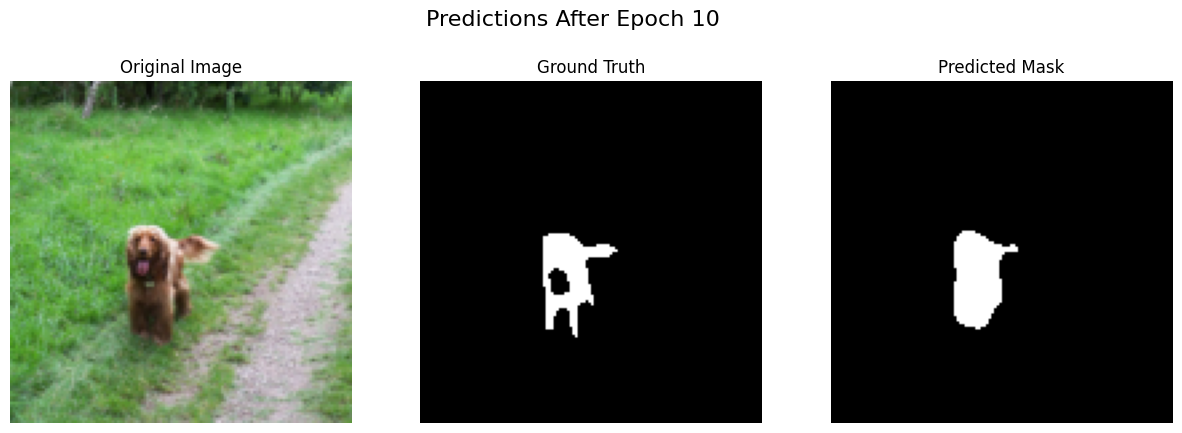

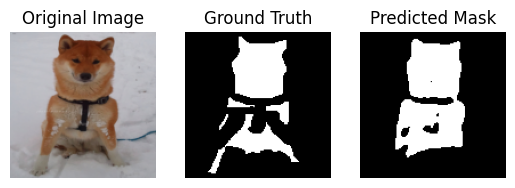

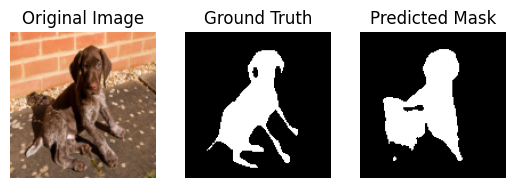

--- Epoch [11/25] Finished --- Avg Loss: 0.1525 --- LR: 0.0001 ---
--- Epoch [12/25] Finished --- Avg Loss: 0.1470 --- LR: 0.0001 ---
--- Epoch [13/25] Finished --- Avg Loss: 0.1433 --- LR: 0.0001 ---
--- Epoch [14/25] Finished --- Avg Loss: 0.1408 --- LR: 0.0001 ---
--- Epoch [15/25] Finished --- Avg Loss: 0.1354 --- LR: 1e-05 ---


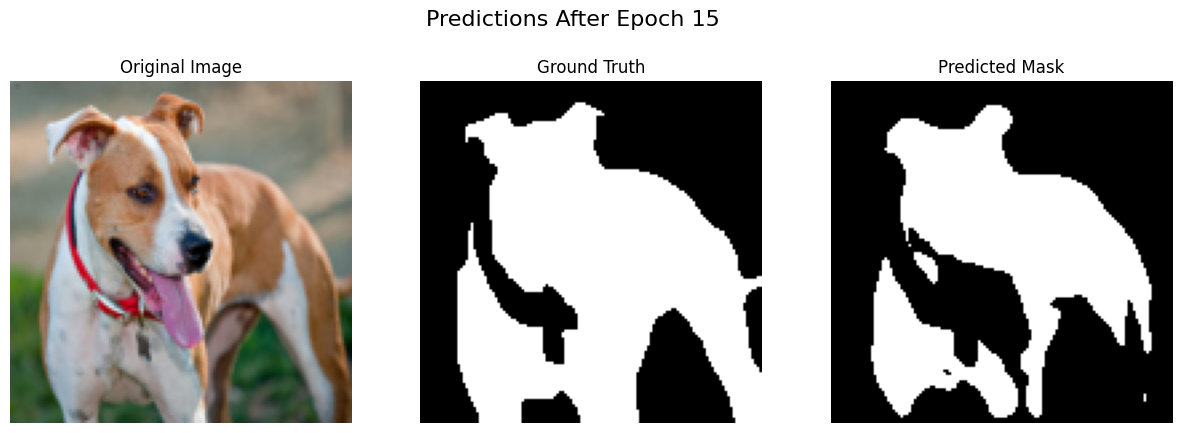

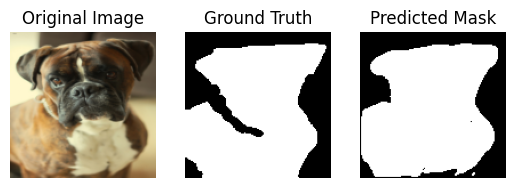

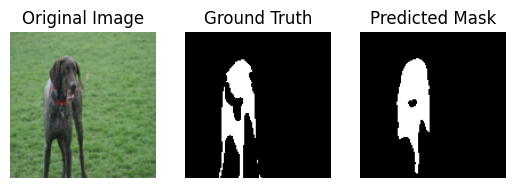

--- Epoch [16/25] Finished --- Avg Loss: 0.1338 --- LR: 1e-05 ---
--- Epoch [17/25] Finished --- Avg Loss: 0.1325 --- LR: 1e-05 ---
--- Epoch [18/25] Finished --- Avg Loss: 0.1317 --- LR: 1e-05 ---
--- Epoch [19/25] Finished --- Avg Loss: 0.1316 --- LR: 1e-05 ---
--- Epoch [20/25] Finished --- Avg Loss: 0.1312 --- LR: 1e-05 ---


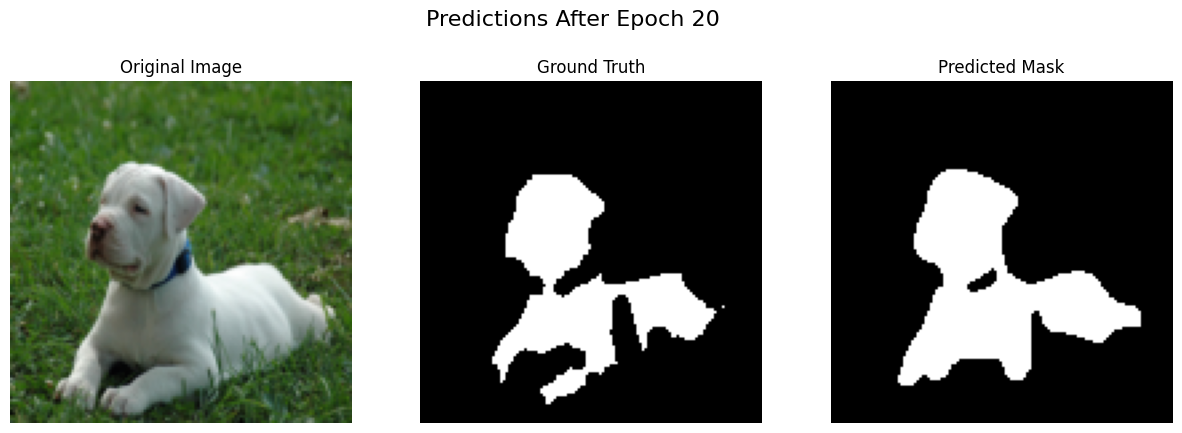

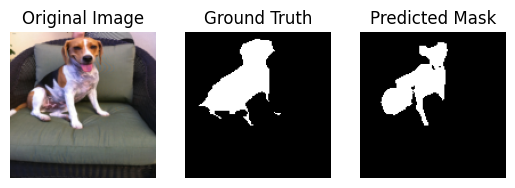

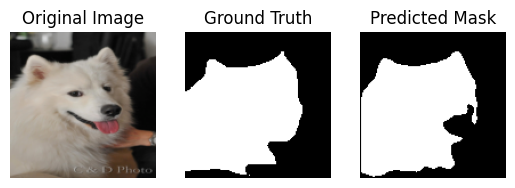

--- Epoch [21/25] Finished --- Avg Loss: 0.1304 --- LR: 1e-05 ---
--- Epoch [22/25] Finished --- Avg Loss: 0.1303 --- LR: 1.0000000000000002e-06 ---
--- Epoch [23/25] Finished --- Avg Loss: 0.1304 --- LR: 1.0000000000000002e-06 ---
--- Epoch [24/25] Finished --- Avg Loss: 0.1292 --- LR: 1.0000000000000002e-06 ---
--- Epoch [25/25] Finished --- Avg Loss: 0.1299 --- LR: 1.0000000000000002e-06 ---


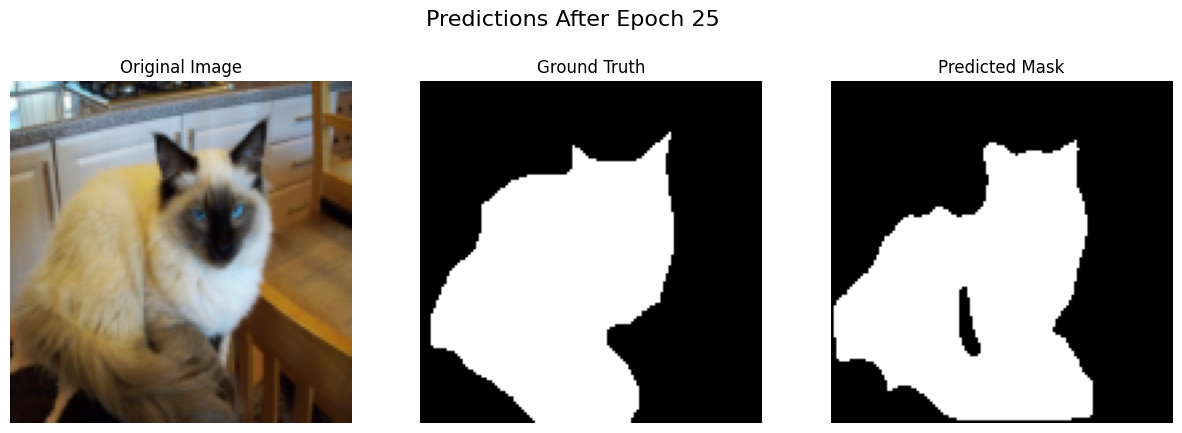

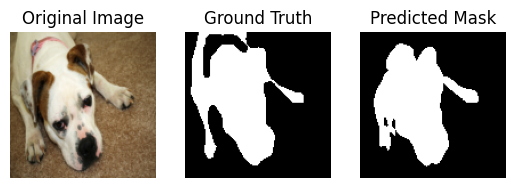

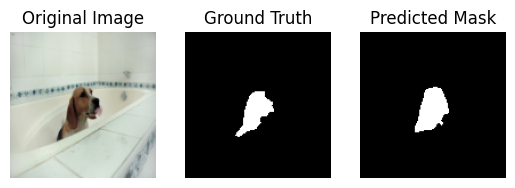

Training finished.


In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision.datasets import OxfordIIITPet
from torchvision.transforms import v2 as T
import matplotlib.pyplot as plt


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )
        # Downsampling path (Encoder)
        self.encoder1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.output_layer = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x); p1 = self.pool1(e1)
        e2 = self.encoder2(p1); p2 = self.pool2(e2)
        e3 = self.encoder3(p2); p3 = self.pool3(e3)
        e4 = self.encoder4(p3); p4 = self.pool4(e4)
        b = self.bottleneck(p4)
        d4 = self.decoder4(torch.cat((e4, self.upconv4(b)), dim=1))
        d3 = self.decoder3(torch.cat((e3, self.upconv3(d4)), dim=1))
        d2 = self.decoder2(torch.cat((e2, self.upconv2(d3)), dim=1))
        d1 = self.decoder1(torch.cat((e1, self.upconv1(d2)), dim=1))
        return self.output_layer(d1)


class PetDataset(OxfordIIITPet):
    def __init__(self, root, split, common_transforms=None):
        super().__init__(root=root, split=split, download=True, target_types="segmentation")
        self.common_transforms = common_transforms
        # Define image-specific transforms here
        self.normalize_image = T.Compose([
            T.ToDtype(torch.float32, scale=True),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def __getitem__(self, idx):
        image, mask = super().__getitem__(idx)


        if self.common_transforms is not None:
            image, mask = self.common_transforms(image, mask)


        mask = (mask == 1).to(torch.float32)


        image = self.normalize_image(image)

        return image, mask


def show_predictions(model, loader, device, epoch):
    model.eval()
    images, masks = next(iter(loader))
    images = images.to(device)

    with torch.no_grad():
        outputs = model(images)
        preds = torch.sigmoid(outputs) > 0.5


    inv_normalize = T.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )

    plt.figure(figsize=(15, 5))
    plt.suptitle(f'Predictions After Epoch {epoch+1}', fontsize=16)

    for i in range(min(3, len(images))):
        img_display = inv_normalize(images[i]).cpu().permute(1, 2, 0).clamp(0, 1)

        plt.subplot(1, 3, 1)
        plt.imshow(img_display)
        plt.title('Original Image'); plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(masks[i].cpu().squeeze(), cmap='gray')
        plt.title('Ground Truth'); plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(preds[i].cpu().squeeze(), cmap='gray')
        plt.title('Predicted Mask'); plt.axis('off')

        plt.show()


if __name__ == '__main__':
    IMG_SIZE = 128
    BATCH_SIZE = 32
    LEARNING_RATE = 0.001
    NUM_EPOCHS = 25
    DATA_DIR = "./data"

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")


    common_transforms = T.Compose([
        T.Resize((IMG_SIZE, IMG_SIZE)),
        T.ToImage(),
    ])

    train_dataset = PetDataset(root=DATA_DIR, split="trainval", common_transforms=common_transforms)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

    val_dataset = PetDataset(root=DATA_DIR, split="test", common_transforms=common_transforms)
    val_loader = DataLoader(val_dataset, batch_size=3, shuffle=True)


    model = UNet(in_channels=3, out_channels=1).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


    print("\nStarting Training on Oxford-IIIT Pet Dataset...")
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        current_lr = optimizer.param_groups[0]['lr']

        print(f"--- Epoch [{epoch+1}/{NUM_EPOCHS}] Finished --- Avg Loss: {epoch_loss:.4f} --- LR: {current_lr} ---")

        scheduler.step()


        if (epoch + 1) % 5 == 0:
            show_predictions(model, val_loader, device, epoch)

    print("Training finished.")

IoU-ratio of overlapping pixels of predicted mask and ground truth